![](img/urban.jpg)

# Image Classification: Urban Sound Classification

This is a very interesting topic I never thought of, we use a Convolution Neural Network(CNN), to classify the spectrogram. This is becasue CNN works better in detecting local feature patterns (edges etc) in different parts of the image and are also good at capturing hierarchical features which become subsequently complex with every layer as illustrated in the image.

![](img/heir_feat.png)

Despite a neural network’s inability to accurately detect foreign high-level features (i.e. faces, bodies, words, labels), the low-level features (i.e. edges, textures, colours) are reliably transferable because of their great abundance and variety in typical training images. 

## Audio 

When we hear a sound, we don't get air molecules hitting our ears like a wind. We just hear a sound, that is becauses air is medium that transport the energy (sound), and the medium itself is not being transferred. So, the waves we see from sound wave plot is not plotting up and down movement of air, but it's plotting compression and rarefaction of air particles. What looks like a crest in sound, wave air molecules are more spread out. And following the same logic, what looks like equilibrim (0 on the y-axis) is the ambient pressure present before sound was produced.

## [Urban Sounds Dataset](https://urbansounddataset.weebly.com/urbansound8k.html)

With the basic understading of sound and sound wave plot, we can take a peek at our dataset.

This dataset contains 8732 labeled sound exerpts (<=4s) of urban sounds from 10 classes: `air_conditioner, car_horn, children_playing, dog_bark, drilling, enginge_idling, gun_shot, jackhammer, siren, and street_music`. The classes are drawn from the urban sound taxonomy. For a detailed description of the dataset and how it was compiled please refer to our paper.
All excertps are taken from field recordings uploaded to [FreeSound](www.freesound.org). The fles are pre-sorted into 10 folds (folders named fold1-fold10) to help in the reproduction of and comparison with the automatic classificaton results in the paper.

You can use the magic command bellow to download the data
```
!wget https://goo.gl/8hY5ER
!tar xf 8hY5ER
```

## Imports

In [45]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [46]:
from fastai import *
from fastai.vision import *
from scipy.io import wavfile as wav
from IPython.display import Audio

import struct
import librosa
import librosa.display

In [4]:
plt.style.use(['dark_background'])

## Paths

In [5]:
DATA_PATH = Path('data/urban_sound8k')
AUDIO_PATH = DATA_PATH/'audio'
SPEC_PATH = PATH = DATA_PATH/'spectro'
DATA_PATH.ls()

[PosixPath('data/urban_sound8k/spectrog'),
 PosixPath('data/urban_sound8k/metadata.csv'),
 PosixPath('data/urban_sound8k/.DS_Store'),
 PosixPath('data/urban_sound8k/.ipynb_checkpoints'),
 PosixPath('data/urban_sound8k/audio')]

## Data preview

In [6]:
df = pd.read_csv(DATA_PATH/'metadata.csv')
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


As observed, the meta-data contains 8 columns.
- `slice_file_name`: name of the audio file
- `fsID`: [FreeSound ID](www.freesound.org) of the recording where the exerpt is taken from
- `start`: start time of the slice
- `end`: end time of the slice
- `salience`: salience rating of the sound. 1 = foreground, 2 = background
- `fold`: the fold # (1-10) to which this file has been allocated
- `classID` and `class`

The audio data has been already sliced and excerpted and even allocated to 10 different folds. Some of the excerpts are from the same original file but different slice. If one slice from a certain recording was in training data, and a different slice from the same recording was in test data, this might increase the accuracy of a final model falsely. Thanks to the original research, this has also been taken care of by allocating slices into folds such that all slices originating from the same [FreeSound](www.freesound.org) recording go into the same fold.

In [7]:
folds = range(1,11)
class_dist = pd.DataFrame([df[df.fold==fo]['class'].value_counts() for fo in folds],
                     index=[f'fold{fo}' for fo in folds])
class_dist

,jackhammer,air_conditioner,drilling,dog_bark,children_playing,street_music,engine_idling,siren,car_horn,gun_shot
fold1,120,100,100,100,100,100,96,86,36,35
fold2,120,100,100,100,100,100,100,91,42,35
fold3,120,100,100,100,100,100,107,119,43,36
fold4,120,100,100,100,100,100,107,166,59,38
fold5,120,100,100,100,100,100,107,71,98,40
fold6,68,100,100,100,100,100,107,74,28,46
fold7,76,100,100,100,100,100,106,77,28,51
fold8,78,100,100,100,100,100,88,80,30,30
fold9,82,100,100,100,100,100,89,82,32,31
fold10,96,100,100,100,100,100,93,83,33,32


In [8]:
total_dist = df['class'].value_counts(normalize=True)
total_dist

dog_bark            0.114521
engine_idling       0.114521
children_playing    0.114521
jackhammer          0.114521
air_conditioner     0.114521
drilling            0.114521
street_music        0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: class, dtype: float64

There are two classes (car_horn, gun_shot) which have a bit less than half amount of entries compared to other 8 classes. Still and all, it doesn't look like it is uncomfortably unbalanced, so for the moment, I have decided not to consider any data augmentation for these two minority classes.

Before I go any further into any detail, let's listen to a wav file, and see what it sounds like.

In [51]:
file  = '100648-1-0-0.wav' 
label = df.loc[df.slice_file_name == file]['class'].item()
fold  = df.loc[df.slice_file_name == file]['fold'].item()
fname = f'{AUDIO_PATH}/fold{fold}/{file}' 
display(label)
display(Audio(fname))

'car_horn'

## WAVE file format

Intuitively, you would ask what is in a WAVE file. In a WAVE, there's not only digital sound data but also contains a header of all the information about the data format. Below picture shows what kind of information is available,

![](img/wav_format.png)

Let's parse the WAV format information for further exploring the data.

In [10]:
def wav_parser(file):
    label = df.loc[df.slice_file_name == file]['class'].item()
    fold  = df.loc[df.slice_file_name == file]['fold'].item()
    fname = f'{AUDIO_PATH}/fold{fold}/{file}' 
    with open(fname, 'rb') as f:
        header = f.read(36)
        numChannel = struct.unpack('<H', header[22:24])[0]
        sampleRate = struct.unpack('<I', header[24:28])[0]
        bitPerSamp = struct.unpack('<H', header[34:])[0]
    return (numChannel, sampleRate, bitPerSamp)

wav_parser(file)

(2, 44100, 16)

Now we can use this `wav_parser()` to add additional information to our data frame to see what kind of different data type exist in our dataset, and how they are distributed.

In [11]:
#df.apply(lambda x: wav_parser(x.slice_file_name), axis=1)
df[['nch','sr','bps']] = pd.DataFrame([wav_parser(i) for i in df.slice_file_name])

In [12]:
df.to_csv(DATA_PATH/'metadata_full.csv', index=False)

In [13]:
df = pd.read_csv(DATA_PATH/'metadata_full.csv')

In [14]:
df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,nch,sr,bps
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,2,44100,16
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,2,44100,16
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,2,44100,16
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,2,44100,16
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,2,44100,16


In [15]:
display(df.nch.value_counts())
display(df.bps.value_counts())
display(df.sr.value_counts())

2    7993
1     739
Name: nch, dtype: int64

16    5758
24    2753
32     169
8       43
4        9
Name: bps, dtype: int64

44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: sr, dtype: int64

Uh oh. By taking a look at the statistical information about `sr`, `nch` and `bps`, apparently, the signal characteristic vary from file to file.

1. The most worrying part is the `sampleRate(sr)`
2. `numOfChannel(nch)` can be simplified by either extracting data from only one channel, or averaging the values of two channels.
3. `bitPerSample(bps)` is a a problem of inconsist intensity representation, in intuition, it can be prepared by normalizing the values with $\frac{x-min()}{max()-min()}$ or $\frac{x-mean()}{stdev()}$

## Librosa

Luckily we already have a wonderful library called Librosa which does all the conversion for us, hooray! (The actual sample rate conversion part in Librosa is done by either [Resampy](https://resampy.readthedocs.io/en/stable/) by default or [Scipy's resampling](https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.resample.html)).

By default, Librosa will convert the sampling rate to 22.05khz, as well as reducing the number of channels to 1(mono), and normalize the data so that the values will range from -1 to 1.

In [16]:
y,sr = librosa.load(fname)
orig_sr,orig_y = wav.read(fname)

print('original sample rate:', orig_sr)
print('converted sample rate:', sr)
print('original wav file min~max range:', np.min(orig_y),'~',np.max(orig_y))
print('converted wav file min~max range:', np.min(y),'~',np.max(y))

original sample rate: 44100
converted sample rate: 22050
original wav file min~max range: -5668 ~ 6242
converted wav file min~max range: -0.17049879 ~ 0.18850903


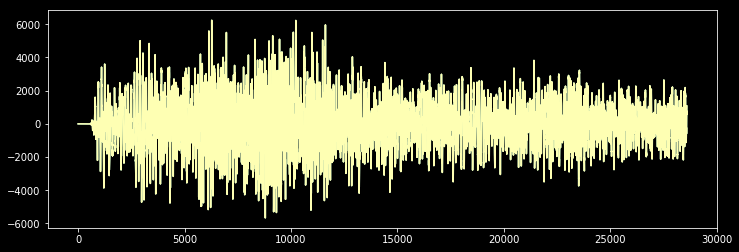

In [17]:
plt.figure(figsize=(12,4))
plt.plot(orig_y);

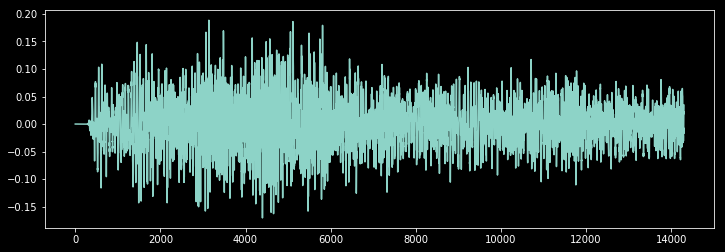

In [18]:
plt.figure(figsize=(12,4))
plt.plot(y);

## Convert WAVE to Spectrogram

Speed up the converting processing by using `ProcessPoolExecuter`

In [99]:
def wav2spectrogram(fname):
    try:
        save = str(fname).replace(AUDIO_PATH.name, SPEC_PATH.name).replace('.wav', '.png')
        if(Path(save).is_file() == False):
            y,sr = librosa.load(fname)
            S = librosa.feature.melspectrogram(y=y, sr=sr)#, n_mels=128)
            log_S = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            Path(save).parent.mkdir(exist_ok=True, parents=True)
            # save a figure without rim
            plt.savefig(save, dpi=200, bbox_inches='tight',pad_inches=0)
            plt.close('all')
    except Exception as e: print(f"Error {fname} {e}")

import multiprocessing
from concurrent.futures import ProcessPoolExecutor, as_completed 
default_workers = multiprocessing.cpu_count()

def multi_processing(fnames, max_workers=default_workers):
    if max_workers:
        with ProcessPoolExecutor(max_workers=max_workers) as ex:
            features = [ex.submit(wav2spectrogram, fn) for fn in fnames]
            for f in progress_bar(as_completed(features), total=len(fnames)): pass
    else:
        for fn in progress_bar(fnames): wav2spectrogram(fn)

# Debug script           
#files = list(AUDIO_PATH.glob('*/*.wav'))[20:8000:55]
#multi_processing(files)

In [ ]:
files = list(AUDIO_PATH.glob('*/*.wav'))
multi_processing(files)

Remove redundant files and folder in the training dataset. `pathlib.rmdir()` only removes 'empty' directory, so I create a function, `rmdir()` to fully delete a target folder.

In [100]:
def rmdir(path):
    for sub in path.iterdir():
        if sub.is_dir():  delete_folder(sub)
        else:             sub.unlink()
    path.rmdir()

[rmdir(o) for o in DATA_PATH.glob('**/*check*') if o.is_dir()];

## Data preparation and sanity check

The new `data_block` API is definitely the most flexible method to prepare data for training, especially cross-validaton scenario. This method is also very systematic,
1. `.from_folder`: read all items(traing/validation) in PATH
2. `.label_from_re`: label every item by parsing filename using regex 
3. `.split_by_files`: split out a validation set by a list of filenames
4. `datasets`: assign a genre to the dataset, i.e. ImageClassificationDataset, SegmentationDataset, etc. 
5. `transform`: assign data transform rules
6. `databunch`: assign dataloader rules
7. `normalize`: assign normalization rules

In [ ]:
folds = range(1, 11)
valid_fos = [1]
train_fos = list(set(folds) - set(valid_fos))
valid_fns = [fn for fo in valid_fos for fn in (PATH/f'fold{fo}').iterdir()]
train_fns = [fn for fo in train_fos for fn in (PATH/f'fold{fo}').iterdir()]

tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

pat = r"(\d*)-\d*-\d*.png$"
data = (ImageFileList.from_folder(PATH)
        .label_from_re(pat=pat)
        .split_by_files(valid_fns)
        .datasets(ImageClassificationDataset)
        .transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [92]:
display(data.stats.numpy())
display(imagenet_stats)

[tensor([0.6539, 0.2650, 0.4085]), tensor([0.3121, 0.1953, 0.1250])]

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [73]:
len(data.train_ds), len(data.valid_ds)

(7859, 873)

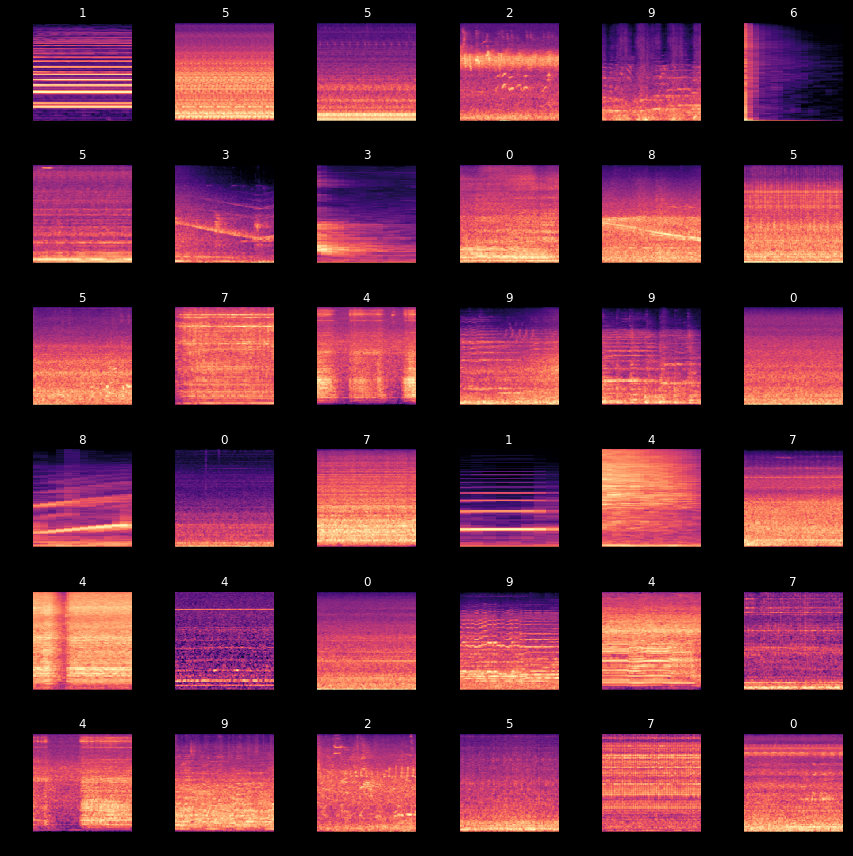

In [74]:
data.show_batch(rows=6, figsize=(12,12))

## Train

In [87]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [88]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


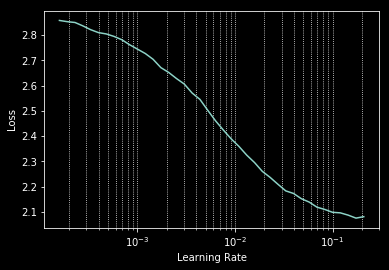

In [89]:
learn.recorder.plot(40,10)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [90]:
learn.fit_one_cycle(6, max_lr=slice(2e-3,4e-2))

Total time: 03:31
epoch  train_loss  valid_loss  error_rate
1      0.887294    0.809202    0.264605    (00:35)
2      0.772582    2.379487    0.474227    (00:33)
3      0.665246    1.137854    0.285223    (00:35)
4      0.452997    0.758138    0.202749    (00:35)
5      0.283012    0.796255    0.222222    (00:36)
6      0.173780    0.837303    0.216495    (00:35)



In [28]:
learn.save('cv-1-stage-1')

In [29]:
learn.load('cv-1-stage-1')

In [93]:
learn.unfreeze()

In [94]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


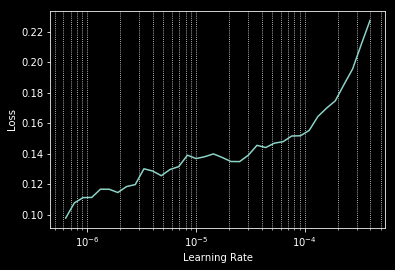

In [96]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [97]:
#learn.fit_one_cycle(10, max_lr=slice(2e-5,4e-5))
learn.fit_one_cycle(10)

Total time: 06:00
epoch  train_loss  valid_loss  error_rate
1      0.454022    1.949922    0.384880    (00:35)
2      0.455970    1.439320    0.359679    (00:36)
3      0.407220    1.872567    0.428408    (00:35)
4      0.322246    1.120192    0.337915    (00:35)
5      0.243047    1.177023    0.310424    (00:36)
6      0.178000    1.226565    0.326460    (00:36)
7      0.099746    1.135238    0.279496    (00:36)
8      0.056662    1.083869    0.271478    (00:36)
9      0.023053    1.141102    0.229095    (00:36)
10     0.020199    1.160764    0.226804    (00:36)



In [40]:
folds = range(1, 11)
valid_fos = [5]
train_fos = list(set(folds) - set(valid_fos))
valid_fns = [fn for fo in valid_fos for fn in (PATH/f'{fo}').iterdir()]
train_fns = [fn for fo in train_fos for fn in (PATH/f'{fo}').iterdir()]

tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

pat = r"(\d*)-\d*-\d*.png$"
data = (ImageFileList.from_folder(PATH)
        .label_from_re(pat=pat)
        .split_by_files(valid_fns)
        .datasets(ImageClassificationDataset)
        .transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

In [49]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [42]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


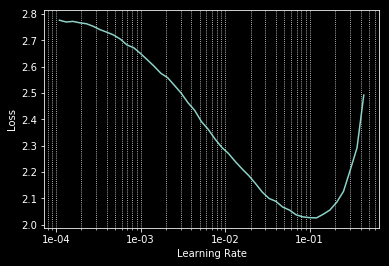

In [45]:
learn.recorder.plot(38)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [50]:
learn.fit_one_cycle(4, max_lr=slice(5e-4,2e-2))

Total time: 01:16
epoch  train_loss  valid_loss  error_rate
1      0.849773    0.860545    0.255342    (00:19)
2      0.596798    0.643536    0.202991    (00:19)
3      0.340511    0.460527    0.146368    (00:19)
4      0.179997    0.474826    0.147436    (00:19)



In [51]:
learn.unfreeze()

In [52]:
learn.unfreeze

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


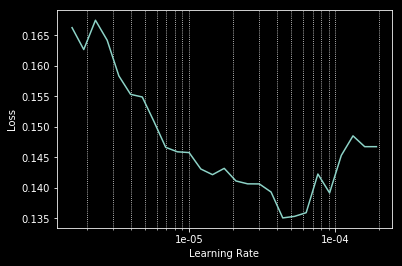

In [56]:
learn.recorder.plot(15, 15)
plt.gca().grid(axis='x', which='both', linestyle=':')

In [57]:
learn.fit_one_cycle(10, max_lr=slice(3e-4,4e-5))

Total time: 04:10
epoch  train_loss  valid_loss  error_rate
1      0.198725    0.486042    0.146368    (00:25)
2      0.196745    0.753046    0.186966    (00:24)
3      0.174240    0.674620    0.155983    (00:24)
4      0.160747    0.749937    0.193376    (00:25)
5      0.105407    0.708772    0.182692    (00:25)
6      0.065782    0.430141    0.134615    (00:25)
7      0.031035    0.419608    0.119658    (00:24)
8      0.016291    0.428926    0.110043    (00:24)
9      0.007772    0.379700    0.103632    (00:25)
10     0.005146    0.387813    0.099359    (00:25)



## Train over 10 folds

> Don't evaluate just on one split. Use 10-fold (not 5-fold) cross validation and average the scores. We strongly advise against this. Instead, perform 10-fold cross validation using the provided folds and report the average score.

By creator's comment and from scoring high perspective, cross validation is highly recommended. However we all know in real producton, cross validataion is rarely be used due to,
1. time consuming
2. you don't want to split the dependent variables if they are time dependent

In [ ]:
folds = range(1, 11)
for fo in folds:
    
    print(f'++ training: {fo}')
    
    valid_fos = [fo]
    train_fos = list(set(folds) - set(valid_fos)) 
    valid_fns = [fn for fo in valid_fos for fn in (PATH/f'{fo}').iterdir()]
    train_fns = [fn for fo in train_fos for fn in (PATH/f'{fo}').iterdir()]
    
    pat = r"(\d*)-\d*-\d*.png$"
    data = (ImageFileList.from_folder(PATH)
            .label_from_re(pat=pat)
            .split_by_files(valid_fns)
            .datasets(ImageClassificationDataset)
            .transform(tfms=tfms, size=224)
            .databunch(bs=64)
            .normalize(imagenet_stats))
    
    learn = create_cnn(data, models.resnet34, metrics=error_rate)
    
    learn.fit_one_cycle(3)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(3, max_lr=slice(9e-4,2e-2))

## Further

There are two benchmark in my knowledge,
1. According to the latest [publication](https://arxiv.org/abs/1608.04363) on the [dataset's](https://urbansounddataset.weebly.com/publications.html) website, the state-of-the-art mean accuracy  achieved was 79%. It should be noted that is with extensive audio specific augmentation, and without augmentation their top accuracy was ***74%***.
2. One of member @fastai forum: mean accuracy across the 10 folds of ***80.5%***
> 1-0.1*(0.231+0.217+0.258+0.168+0.111+0.191+0.232+0.255+0.134+0.150)

### TODOs
1. [ ] Implement augmentations
    - http://www.ofai.at/~jan.schlueter/pubs/2015_ismir.pdf
2. [x] Multi-process format converting
3. [ ] `.normalize()`
    - [ ] Play around with different `stats` other than `imagenet_stats`
        - My gut feeling about this, since normalization is meant to speed up convergence, approximates should be good enough. Precise numbers may not be essential.
        - JH: If you're using a pretrained model you need to use the same stats it was trained with.
    - [ ] What is the hunch behind it
    - [ ] Experiment on [stats](https://forums.fast.ai/t/normalize-for-pretrained-false-resnet/28963/3)
4. [ ] Another way to think about this is to use a Recurrent Neural Network(RNN) to capture the sequential information in sound data by passing one frame at a time, but as in most cases, CNN has outperformed standalone RNNs - we haven’t used it in this particular experiment. In many cases, RNN are used along with CNN to improve performance of networks and we would be experimenting with those architectures in the future.
